# 3D Drone 
---
这里将开发一个3D环境下的无人机控制器。课程分为两部分：   
1. 设计一个捕捉和描述无人机动力学特性的类    
2. 开发一个无人机控制器    
在练习的最后，执行一段简单的三维飞行，并观察控制器的表现，检查无人机是否跟随目标路径。

<div class="container" style="width: 100%;">
 <div class="D1 col-sm-6" style="width: 40%;">
   <img src="Drone1.png" height="100">
 </div>
 <div class="D2 col-sm-6" style="width: 50%;">
   <img src="Drone2.png" height="300">
 </div>
</div>

### Drone dynamics 
我们应该记住无人机可以执行的动作。它能够沿着x、y和z轴移动。和以往的练习一致，同样选择z轴向下定向。无人机还能够绕x轴横滚，绕y轴俯仰，绕z轴旋转，我们需要检查无人机在两个坐标系下姿态的变化$（\phi,\theta,\psi和p,q,r）$。其中一个为惯性坐标系，相对于周围环境；另一个局部坐标系依附在无人机本身。你将负责执行适当的坐标转换操作，并在适当的坐标下跟踪必要的变量。

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import math
from math import sin, cos, tan, sqrt
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import jdc
import random

from solution import UDACITYDroneIn3D, UDACITYController
import testing

pylab.rcParams['figure.figsize'] = 10, 10

# Drone  
为了追踪无人机的状态，我们需要12个参数，包括$X = [x,y,z,\phi,\theta,\psi,\dot{x},\dot{y},\dot{z},p,q,r]$, 其中$x$, $y$, 和 $z$是无人机相对于惯性坐标系的位置，$\dot{x}$, $\dot{y}$, 和 $\dot{z}$ 是无人机相对于惯性坐标系各轴的平移速度。$\phi$, $\theta$ 和 $\psi$ 代表无人机在惯性坐标系下的姿态，而$p$, $q$ 和 $r$则描述无人机在局部坐标系下的角速度。   
相应地，状态向量在时间上的导数将具有这一种形式：$\dot{X} = [\dot{x},\dot{y},\dot{z},\dot{\phi},\dot{\theta},\dot{\psi},\ddot{x},\ddot{y},\ddot{z},\dot{p},\dot{q},\dot{r}]$ ，12个变量中，仅有3个是在局部坐标系下描述的。   
关注DroneIn3D的属性，参数包括：   
1. 容易测量的静态物理参数：两个马达系数、质量、size、惯性矩
2. 不易测量的动态物理参数：12个状态变量、马达转速
3. 重力系数

In [2]:
class DroneIn3D(UDACITYDroneIn3D):
    
    def __init__(self,
                k_f = 1.0,
                k_m = 1.0,
                m = 0.5,
                L = 0.566, # full rotor to rotor distance
                i_x = 0.1,
                i_y = 0.1,
                i_z = 0.2):
        
        self.k_f = k_f
        self.k_m = k_m
        self.m = m
        self.l = L / (2*sqrt(2)) # perpendicular distance to axes
        self.i_x = i_x
        self.i_y = i_y
        self.i_z = i_z
        
        # x, y, y, phi, theta, psi, 
        # x_dot, y_dot, z_dot, p, q, r
        self.X=np.array([0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0])
        self.omega = np.array([0.0,0.0,0.0,0.0])
        
        self.g = 9.81

为了简化无人机动力学计算中的符号，我们引入对象的属性(@property)，并将它们的值指定为状态向量X中相关变量的值。这些属性将包括 $\phi$, $\theta$, $\psi$, $p$, $q$, $r$。这些值是惯性坐标下的欧拉角和局部坐标下的角速度。

In [3]:
%%add_to DroneIn3D

# euler angles [rad] (in world / lab frame)
@property
def phi(self):
    return self.X[3]

@property
def theta(self):
    return self.X[4]

@property
def psi(self):
    return self.X[5]

# body rates [rad / s] (in body frame)
@property 
def p(self):
    return self.X[9]

@property
def q(self):
    return self.X[10]

@property 
def r(self):
    return self.X[11]


类似地，我们也需要定义螺旋桨产生的力为DroneIn3D的属性：
$F_1 = k_f\omega^2_1$, $F_2 = k_f\omega^2_2$, $F_3 = k_f\omega^2_3$, $F_4 = k_f\omega^2_4$.   
和相对机身向上的合力（上述四个分力的叠加，由此想到后面必然引进转动力矩） $F_{total} = F_1 + F_2 + F_3 + F_4$.    
事实上

In [4]:
%%add_to DroneIn3D

# forces from the four propellers [N]
@property
def f_1(self):
    f = self.k_f*self.omega[0]**2
    return f

@property 
def f_2(self):
    f = self.k_f*self.omega[1]**2
    return f

@property 
def f_3(self):
    f = self.k_f*self.omega[2]**2
    return f

@property 
def f_4(self):
    f = self.k_f*self.omega[3]**2
    return f

# collective force
@property
def f_total(self):
    f_t = self.f_1 + self.f_2 + self.f_3 + self.f_4
    return f_t

接下来，我们将追踪螺旋桨产生的力矩。对于滚转运动，由第一和第四螺旋桨产生的力矩被第二螺旋桨和第三螺旋桨产生的力矩抵消。$L$是X轴与螺旋桨位置之间的距离，等于相邻螺旋桨之间距离的一半。以相同的方式，俯仰运动是因为由第一和第二螺旋桨所产生的力矩和由第三和第四螺旋桨产生的力矩的不匹配产生的。    
与滚转和俯仰比较，偏航运动是由螺旋桨沿$Z$轴产生的力矩的反作用力之间的不匹配来实现的。螺旋桨产生的力矩方向与它的旋转方向相反，大小与角速度的平方成正比。 
$$
\begin{align}
\tau_x &= (F_1 + F_4 - F_2 - F_3)l \\
\tau_y &= (F_1 + F_2 - F_3 - F_4)l \\
\tau_z &= \tau_1 + \tau_2 + \tau_3 + \tau_4
\end{align}
$$

其中， $\tau_1 = k_m \omega^2_1$, $\tau_2 = -k_m \omega^2_2$, $\tau_3 = k_m \omega^2_3$, $\tau_4 = -k_m \omega^2_4$.       
在符号比较中，螺旋桨1和3顺时针旋转，产生逆时针且带负号的扭矩值；而螺旋桨2和4逆时针旋转，产生顺时针带正号的扭矩值。

In [5]:
%%add_to DroneIn3D

# reactive moments [N * m]
@property
def tau_1(self):
    tau = self.k_m * self.omega[0]**2
    return tau
    
@property
def tau_2(self):
    tau = -self.k_m * self.omega[1]**2
    return tau

@property
def tau_3(self):
    tau = self.k_m * self.omega[2]**2
    return tau

@property
def tau_4(self):
    tau = -self.k_m * self.omega[3]**2
    return tau

# moments about axes [N * m]
@property
def tau_x(self):
    tau = self.l*(self.f_1 + self.f_4 - self.f_2 - self.f_3)
    return tau

@property
def tau_y(self):
    tau = self.l*(self.f_1 + self.f_2 - self.f_3 - self.f_4)
    return tau

@property
def tau_z(self):
    tau = self.tau_1 + self.tau_2 + self.tau_3 + self.tau_4
    return tau

## Exercise 1 
### 1.1 Setting the propeller angular velocities (Drone) 设定螺旋桨的旋转角速度    
基于“来自控制器的输入”，可以设置螺旋桨的旋转角速度。为达到该目的，我们将求解以下线性方程。第一行表示竖直加速度，第二行表示滚转方程，第三行为俯仰方程，最后一行来自偏航方程。
$$
\begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\\ 1 & -1 & 1 & -1 \end{pmatrix} \times \begin{pmatrix} \omega^2_1 \\ \omega^2_2 \\ \omega^2_3\\ \omega^2_4 \end{pmatrix} = \begin{pmatrix} \bar{c} \\ \bar{p} \\ \bar{q} \\ \bar{r} \end{pmatrix}
$$

我们需要将来自控制器的输入转化为这些变量： $\bar{c}$, $\bar{p}$, $\bar{q}$, $\bar{r}$

从控制器获取的 $c$ 值等于 $\frac{F}{m} = c$, 对于方程 $(\omega^2_1 + \omega^2_2 + \omega^2_3 + \omega^2_4) = \bar{c}$ 螺旋桨变换公式为 $\bar{c} = \frac{F}{k_f} = \frac{c m }{k_f}$.

对于roll、pitch和yaw， $\bar{u}_p = \dot{p} = \frac{\tau_x}{I_x}$ , $\bar{u}_q = \dot{q} = \frac{\tau_y}{I_y}$ , $\bar{u}_r = \dot{r} = \frac{\tau_z}{I_z}$. 用下面的式子，将它们转化为无量纲形式 
$$
\begin{align}
\bar{p} &= \frac{I_x \bar{u}_p}{k_f l } \\
\bar{q} &= \frac{I_y \bar{u}_q}{k_f l } \\
\bar{r} &= \frac{I_z \bar{u}_r}{k_m } \\
\end{align}
$$    

#### LEECHAN:    
这里没有涉及控制策略，只是将控制器的输出作为该转换器的输入，转换器输出螺旋桨角速度设定值。    
控制器的输出是u_bar == 某个加速度物理量(例如:u_bar_p==p_dot。注：P_dot实际上是加速度)。但是求解omega的线性方程中并不是用u_bar。例如，控制器输出是u_bar_p，而线性方程用的是p_bar，引进p_bar应该是为了简化线性方程式的表达。

In [6]:
%%add_to DroneIn3D

# Exercise 1.1

def set_propeller_angular_velocities(self,
                                    c,
                                    u_bar_p,
                                    u_bar_q,
                                    u_bar_r):
    
    # transform input from controller to c_bar,p_bar,q_bar,r_bar
    c_bar = -c * self.m / self.k_f
    p_bar = u_bar_p * self.i_x / (self.k_f * self.l)
    q_bar = u_bar_q * self.i_y / (self.k_f * self.l)
    r_bar = u_bar_r * self.i_z / self.k_m 

    # solve the linear equation to obtain and set omega value
    omega_4 = (c_bar + p_bar - r_bar - q_bar)/4
    omega_3 = (r_bar - p_bar)/2 + omega_4
    omega_2 = (c_bar - p_bar)/2 - omega_3
    omega_1 = c_bar - omega_2 - omega_3 - omega_4
        
    self.omega[0] = -np.sqrt(omega_1)
    self.omega[1] = np.sqrt(omega_2)
    self.omega[2] = -np.sqrt(omega_3)
    self.omega[3] = np.sqrt(omega_4)

In [7]:
testing.test_exercise_1_1(DroneIn3D)

Tests pass - exercise 1.1


### 1.2 Calculate Rotation Matrix 计算旋转矩阵

为了能够在局部坐标和世界坐标下转换加速度，必须借助旋转矩阵 $R$ :

$$R = R_z(\psi) \times R_y(\theta) \times R_x(\phi)$$

绕$x$, $y$, 和 $z$ 轴的旋转矩阵为:

\begin{alignedat}{1}R_{x}(\phi )&={\begin{bmatrix}1&0&0\\0&\cos \phi &-\sin \phi \\[3pt]0&\sin \phi &\cos \phi \\[3pt]\end{bmatrix}}\\[6pt]R_{y}(\theta )&={\begin{bmatrix}\cos \theta &0&\sin \theta \\[3pt]0&1&0\\[3pt]-\sin \theta &0&\cos \theta \\\end{bmatrix}}\\[6pt]R_{z}(\psi )&={\begin{bmatrix}\cos \psi &-\sin \psi &0\\[3pt]\sin \psi &\cos \psi &0\\[3pt]0&0&1\\\end{bmatrix}}\end{alignedat}

In [8]:
%%add_to DroneIn3D

# Exercise 1.2

def R(self):
    r_x = np.array([[1, 0, 0],
                    [0, cos(self.phi), -sin(self.phi)],
                    [0, sin(self.phi), cos(self.phi)]])
    
    r_y = np.array([[cos(self.theta), 0, sin(self.theta)],
                    [0, 1, 0],
                    [-sin(self.theta), 0, cos(self.theta)]])
        
    r_z = np.array([[cos(self.psi), -sin(self.psi), 0],
                    [sin(self.psi), cos(self.psi), 0],
                    [0,0,1]])
        
    r = np.matmul(r_z,np.matmul(r_y,r_x))
    return r

In [9]:
testing.test_exercise_1_2(DroneIn3D)

Tests pass - exercise 1.2


### 1.3 Calculate Linear accelerations 计算线性加速度

沿着$x$，$y $和$z轴的线性加速度可以用矩阵形式来表示，其中$g是由于沿着z轴$Z$方向的重力引起的加速度。$F$是由所有四个螺旋桨产生的合力，并在相局部坐标中指向上。我们需要通过旋转矩阵R将局部坐标下的力转换成惯性坐标下的力，并将结果除以m得到加速度矢量（因为我们关心惯性坐标系下的线性加速度）。

$$
\begin{pmatrix} \ddot{x} \\ \ddot{y} \\ \ddot{z}\end{pmatrix}  = \begin{pmatrix} 0 \\ 0 \\ g\end{pmatrix} + \frac{1}{m}R \begin{pmatrix} 0 \\ 0 \\ -F_{total} \end{pmatrix} 
$$

其中 $R = R(\psi) \times R(\theta) \times R(\phi)$

In [10]:
%%add_to DroneIn3D

# Exercise 1.3

def linear_acceleration(self):
    
    linear_acc = np.array([0,0,self.g]).T + 1.0/self.m * np.matmul(self.R(), np.array([0, 0 ,-self.f_total]).T)
    
    return linear_acc

In [11]:
testing.test_exercise_1_3(DroneIn3D)

Tests pass - exercise 1.3


Exercise 1 ends here! At this point you should press "Next" and continue with the lesson.

------

## Exercise 2
### 2.1 Get $\dot{\omega}$  ( which is just  $\dot{p}$, $\dot{q}$, $\dot{r}$) 获取 $\dot{\omega}$ 
局部坐标下的角加速度可用下列方程式计算。下面同时提供了展开版本。其中$p$是局部坐标下的滚转速率，$q是局部坐标下的俯仰速率，$R是横摆角速度。所有这些变量都以rad/s来衡量。    

$$
I\begin{pmatrix} \dot{p} \\ \dot{q} \\ \dot{r} \end{pmatrix} =\begin{pmatrix} \tau_x  \\ \tau_y  \\ \tau_z  \end{pmatrix} - \begin{pmatrix} p \\ q \\ r \end{pmatrix} \times I \begin{pmatrix} p \\ q \\ r \end{pmatrix}
$$


$$
I_x \dot{p} =  \tau_x - (I_z-I_y) r q \\
I_y \dot{q} =  \tau_y - (I_x-I_z) p r \\
I_z \dot{r} =  \tau_z - (I_y-I_x) q p \\ 
$$

在之后的 `advance_state` 中，你会使用如 $\dot{p}$ 这类变量来更新 $p$:

In [12]:
%%add_to DroneIn3D

def get_omega_dot(self):
    
    # TODO replace with your own implementation
    # return np.array([p_dot, q_dot, r_dot])
    p_dot = self.tau_x/self.i_x - self.r * self.q *(self.i_z - self.i_y)/self.i_x
    q_dot = self.tau_y/self.i_y - self.r * self.p *(self.i_x - self.i_z)/self.i_y
    r_dot = self.tau_z/self.i_z - self.q * self.p *(self.i_y - self.i_x)/self.i_z
    
    return np.array([p_dot, q_dot, r_dot])

In [13]:
testing.test_exercise_2_1(DroneIn3D)

Tests pass - exercise 2.1


Exercise 2 ends here! At this point you should press "Next" and continue with the lesson.

----

## Exercise 3
### 3.1 Getting the rate of change of the Euler angles 获取欧拉角变化率

Instantaneous turn rate in the body frame to an instantaneous change in the Euler angles (world frame) is done with the matrix multiplication derived in the lesson. 
$$
\begin{pmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi}\end{pmatrix} = \begin{pmatrix} 1 & \sin{\phi}\tan{\theta} & \cos{\phi}\tan{\theta} \\ 0 & \cos{\phi} & -\sin{\phi} \\ 0 & \sin{\phi}\sec{\theta} & \cos{\phi}\sec{\theta} \end{pmatrix} \times \begin{pmatrix} p \\ q \\ r \end{pmatrix}
$$

where $\sec{\theta} = \frac{1}{\cos{\theta}}$

In [14]:
%%add_to DroneIn3D

def get_euler_derivatives(self):
    
    euler_rot_mat= np.array([[1, sin(self.phi) * tan(self.theta), cos(self.phi) * tan(self.theta)],
                             [0, cos(self.phi), -sin(self.phi)],
                             [0, sin(self.phi) / cos(self.theta), cos(self.phi) / cos(self.theta)]])
        
        
    derivatives_in_bodyframe =np.array([self.p,self.q,self.r]).T
        
    euler_dot= np.matmul(euler_rot_mat,derivatives_in_bodyframe)
    return euler_dot

In [15]:
testing.test_exercise_3_1(DroneIn3D)

Tests pass - exercise 3.1


### 3.2 Advance state function 更新状态方程
在知道所有描述无人机变化的参数的前提下，新的状态变量可以通过推进$dt$来计算。
状态变量： $X = [x,y,z,\phi,\theta,\psi,\dot{x},\dot{y},\dot{z},p,q,r]$, 且有 $\dot{X} = [\dot{x},\dot{y},\dot{z},\dot{\phi},\dot{\theta},\dot{\psi},\ddot{x},\ddot{y},\ddot{z},\dot{p},\dot{q},\dot{r}]$

接着你将使用下列 method 来更新无人机的状态： `linear_acceleration`, `get_euler_derivatives`, 和 `get_omega_dot`.

In [16]:
%%add_to DroneIn3D

def advance_state(self, dt):
    
    # TODO replace this with your own implementation
    # 
    #   make sure this function returns the new state! 
    #   Some of the code that calls this function will expect
    #   it to return the state, so simply updating self.X 
    #   is not enough (though you should do that in this
    #   method too.)
    
    #   why can't use "self.X += self.X_dot * dt" directly? because we don't known self.X_dot
    
    linear_derivatives = self.X[6:9]  # using the pre state
    linear_acc = self.linear_acceleration()  # derive from current force
    euler_derivatives = self.get_euler_derivatives()  #using the pre state 
    omega_dot = self.get_omega_dot()  # derive from current torque/moment
    
    X_dot = np.concatenate((linear_derivatives, euler_derivatives, linear_acc, omega_dot)) 
    
    self.X += X_dot * dt
    
    return self.X

In [17]:
testing.test_exercise_3_2(DroneIn3D)

Tests pass - exercise 3.2


Exercise 3 ends here! At this point you should press "Next" and continue with the lesson.

-----

前面3个lesson的内容还都是构建“DroneIn3D”类，类的功能越多，构建控制器时就越方便。能够实现这一部分代码，实际上已经表示能够创建无人机的仿真环境。下面开始则是开发该类的控制器。

-----

# 3D controller  
接下来，我们将实现无人驾驶飞机的控制器，该控制器能够在3D环境中控制无人机。从本课中，你已经熟悉了控制器的结构。它由altitude（高度）控制器、position（位置）控制器和attitude（姿态）控制器组成。 

<img src="control1.png" width="800">
姿态控制器分解成更小的控制器，分别负责roll-pitch, yaw 和 body rate（机身角速率）。这里比较难理解的是 body rate controller。
<img src="control2.png" width="600">
创建各个控制器所需的参数对应为：
 - Altitude controller: $k_{p-z}$, $k_{d-z}$
 - Position controller: $k_{p-x}$, $k_{d-x}$, $k_{p-y}$, $k_{d-y}$
 - Roll-Pitch controller: $k_{p-roll}$, $k_{p-pitch}$
 - Yaw controller: $k_{p-yaw}$
 - Body rate controller: $k_{p-p}$, $k_{p-q}$, $k_{p-r}$
    
基于输入参数，我们还可以为高度控制$z$和侧向控制$x$ 和 $y$计算 $\delta$ 和 $\omega_n$。      

In [18]:
class Controller(UDACITYController):
    
    def __init__(self,
                z_k_p=1.0,
                z_k_d=1.0,
                x_k_p=1.0,
                x_k_d=1.0,
                y_k_p=1.0,
                y_k_d=1.0,
                k_p_roll=1.0,
                k_p_pitch=1.0,
                k_p_yaw=1.0,
                k_p_p=1.0,
                k_p_q=1.0,
                k_p_r=1.0):
        
        
        self.z_k_p = z_k_p
        self.z_k_d = z_k_d
        self.x_k_p = x_k_p
        self.x_k_d = x_k_d
        self.y_k_p = y_k_p
        self.y_k_d = y_k_d
        self.k_p_roll = k_p_roll
        self.k_p_pitch = k_p_pitch
        self.k_p_yaw = k_p_yaw
        self.k_p_p = k_p_p
        self.k_p_q = k_p_q
        self.k_p_r = k_p_r
        
        print('x: delta = %5.3f'%(x_k_d/2/math.sqrt(x_k_p)), ' omega_n = %5.3f'%(math.sqrt(x_k_p)))
        print('y: delta = %5.3f'%(y_k_d/2/math.sqrt(y_k_p)), ' omega_n = %5.3f'%(math.sqrt(y_k_p)))
        print('z: delta = %5.3f'%(z_k_d/2/math.sqrt(z_k_p)), ' omega_n = %5.3f'%(math.sqrt(z_k_p)))
        
        self.g= 9.81
    

## Exercise 4

需要注意的是，这里使用的控制器结构和课程中讨论的（以及后面项目要实现的）稍有不同。    
现在，lateral 控制器的任务是产生旋转矩阵元素$\mathbf{R_{13}}$ (also referred to as $b^x$)和$\mathbf{R_{23}}$ (also referred to as $b^y$)的命令值。

### 4.1 Lateral controller 
横向控制器将使用PD控制器来产生无人机旋转矩阵之元素的目标值指令。无人机通过改变机体方向产生侧向加速度，从而在期望的方向上产生非零推力。这将转化为命令旋转矩阵元素$b^ xxc$和$b^ yyc$ (机体要在水平方向上移动，机体必须倾斜/旋转，以产生惯性坐标系下的侧向力。所以感性理解：控制命令——侧向加速度传进Lateral控制器后，输出旋转矩阵)。x方向的控制方程有以下形式：

$$
\begin{align}
\ddot{x}_{\text{command}} &=  c b^x_c \\
\ddot{x}_{\text{command}} &=  k^x_p(x_t-x_a) + k_d^x(\dot{x}_t - \dot{x}_a)+ \ddot{x}_t \\
b^x_c &= \ddot{x}_{\text{command}}/c
\end{align}
$$

对于 $y$ 方向的控制方程有一致的形式。

In [19]:
%%add_to Controller

# Exercise 4.1

def lateral_controller(self,
                      x_target,
                      x_dot_target,
                      x_dot_dot_target,
                      x_actual,
                      x_dot_actual,
                      y_target,
                      y_dot_target,
                      y_dot_dot_target,
                      y_actual,
                      y_dot_actual,
                      c):
    
    # TODO replace with your own implementation
    # return b_x_c, b_y_c
    x_c_dot_dot = self.x_k_p*(x_target-x_actual)+self.x_k_d*(x_dot_target-x_dot_actual)+x_dot_dot_target
    b_x_c = x_c_dot_dot/c
    
    y_c_dot_dot = self.y_k_p*(y_target-y_actual)+self.y_k_d*(y_dot_target-y_dot_actual)+y_dot_dot_target
    b_y_c = y_c_dot_dot/c
    
    return b_x_c, b_y_c

In [20]:
testing.test_exercise_4_1(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 4.1


### 4.2 Roll-Pitch controller

roll-pitch（横滚-俯仰）控制器为一个P控制器，负责控制局部坐标下的横滚率和俯仰率（$p_c$ 和 $q_c$）。首先，它使用P控制器设定给定矩阵元素的期望变化率。 

**Note** - 下表c代表command，a代表actual

$\dot{b}^x_c  = k_p(b^x_c - b^x_a)$

$\dot{b}^y_c  = k_p(b^y_c - b^y_a)$

其中，$b^x_a = R_{13}$ ， $b^y_a = R_{23}$. 给定的值可以通过以下矩阵乘法转换成局部坐标下的角速度。 

$$
\begin{pmatrix} p_c \\ q_c \\ \end{pmatrix}  = \frac{1}{R_{33}}\begin{pmatrix} R_{21} & -R_{11} \\ R_{22} & -R_{12} \end{pmatrix} \times \begin{pmatrix} \dot{b}^x_c \\ \dot{b}^y_c  \end{pmatrix} 
$$


In [21]:
%%add_to Controller

# Exercise 4.2

def roll_pitch_controller(self,
                          b_x_c,
                          b_y_c,
                          rot_mat):
    
    # TODO replace with your own implementation
    # return p_c, q_c

    b_x = rot_mat[0,2]
    b_x_err = b_x_c - b_x
    b_x_p_term = self.k_p_roll * b_x_err
        
    b_y = rot_mat[1,2]
    b_y_err = b_y_c - b_y  
    b_y_p_term = self.k_p_pitch * b_y_err
        
    b_x_commanded_dot = b_x_p_term
    b_y_commanded_dot = b_y_p_term
        
    rot_mat1=np.array([[rot_mat[1,0],-rot_mat[0,0]],[rot_mat[1,1],-rot_mat[0,1]]])/rot_mat[2,2]
        
    rot_rate = np.matmul(rot_mat1,np.array([b_x_commanded_dot,b_y_commanded_dot]).T)
    p_c = rot_rate[0]
    q_c = rot_rate[1]
    
    return p_c, q_c

In [22]:
testing.test_exercise_4_2(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 4.2


Exercise 4 ends here! At this point you should press "Next" and continue with the lesson. 

------

## Exercise 5

### 5.1 Body rate controller

roll, pitch 和yaw的目标指令最终经由body rate控制器，并转换成各轴在局部坐标下的目标旋转加速度。

$p_{\text{error}} = p_c - p$

$\bar{u}_p= k_{p-p} p_{\text{error}}$

$q_{\text{error}} = q_c - q$

$\bar{u}_q= k_{p-q} q_{\text{error}}$

$r_{\text{error}} = r_c - r$

$\bar{u}_r= k_{p-r} r_{\text{error}}$


In [23]:
%%add_to Controller

# Exercise 5.1 

def body_rate_controller(self,
                         p_c,
                         q_c,
                         r_c,
                         p_actual,
                         q_actual,
                         r_actual):
    # TODO replace with your own implementation
    # return u_bar_p, u_bar_q, u_bar_r
    p_err= p_c - p_actual 
    u_bar_p = self.k_p_p * p_err
        
    q_err= q_c - q_actual 
    u_bar_q = self.k_p_q * q_err

    r_err= r_c - r_actual
    u_bar_r = self.k_p_r * r_err
        
    return u_bar_p, u_bar_q, u_bar_r

In [24]:
testing.test_exercise_5_1(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 5.1


### 5.2 Yaw controller

偏航控制从其他方向解耦。使用一个P控制器来控制无人机的偏航。 

$r_c = k_p (\psi_t - \psi_a)$

In [25]:
%%add_to Controller

# Exercise 5.2

def yaw_controller(self,
                   psi_target,
                   psi_actual):
    
    # TODO replace with your own implementation
    # return r_c
    psi_err = psi_target - psi_actual
    r_c = self.k_p_yaw * psi_err
    
    return r_c

In [26]:
testing.test_exercise_5_2(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 5.2


### 5.3 Altitude Controller

线性加速度可由以下线性方程表达：
$$
\begin{pmatrix} \ddot{x} \\ \ddot{y} \\ \ddot{z}\end{pmatrix}  = \begin{pmatrix} 0 \\ 0 \\ g\end{pmatrix} + R \begin{pmatrix} 0 \\ 0 \\ c \end{pmatrix} 
$$

其中 $R = R(\psi) \times R(\theta) \times R(\phi)$. 从方程中解耦出独立的线性加速度有下列形式：

$$
\begin{align}
\ddot{x} &= c b^x \\ 
\ddot{y} &= c b^y \\ 
\ddot{z} &= c b^z +g
\end{align}
$$ 
其中 $b^x = R_{13}$, $b^y= R_{23}$ and $b^z = R_{33}$ 是旋转矩阵最后一列的元素 

我们这样控制竖直方向的加速度: 

$$\bar{u}_1 = \ddot{z} = c b^z +g$$ 

因此 

$$c = (\bar{u}_1-g)/b^z$$  
注意，高度控制（相对于惯性坐标）返回的是合力的标量值（这个值是在机体坐标下描述的）。

在练习中，使用PD控制器控制姿态：

$$\bar{u}_1 = k_{p-z}(z_{t} - z_{a}) + k_{d-z}(\dot{z}_{t} - \dot{z}_{a}) + \ddot{z}_t$$


In [27]:
%%add_to Controller

# Exercise 5.3

def altitude_controller(self,
                       z_target,
                       z_dot_target,
                       z_dot_dot_target,
                       z_actual,
                       z_dot_actual,
                       rot_mat):
    
    # TODO replace with your own implementation
    # return c
    z_err = z_target - z_actual
    z_err_dot = z_dot_target - z_dot_actual
    b_z = rot_mat[2,2]

    p_term = self.z_k_p * z_err
    d_term = self.z_k_d * z_err_dot

    u_1_bar = p_term + d_term + z_dot_dot_target
        
    c = (u_1_bar - self.g)/b_z
    return c

In [28]:
testing.test_exercise_5_3(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 5.3


### Attitude controller (provided)

姿态控制器包含前面已经实现的 roll-pitch控制器，yaw控制器，以及 body rate 控制器。

In [29]:
%%add_to Controller

def attitude_controller(self,
                       b_x_c_target,
                       b_y_c_target,
                       psi_target,
                       psi_actual,
                       p_actual,
                       q_actual,
                       r_actual,
                       rot_mat):

    p_c, q_c = self.roll_pitch_controller(b_x_c_target,
                                          b_y_c_target,
                                          rot_mat)
    
    r_c = self.yaw_controller(psi_target, 
                              psi_actual)
    
    u_bar_p, u_bar_q, u_bar_r = self.body_rate_controller(
        p_c,
        q_c,
        r_c,
        p_actual,
        q_actual,
        r_actual)

    return u_bar_p, u_bar_q, u_bar_r

# Flight planning 

In order to test the developed drone dynamics and the controller, we will execute simple three-dimensional flight with changing yaw angle. 

_Keep in mind that the desired flight path needs to have an analytical form (differentiable for the entirety of the path)._

The selected test path is a figure 8 in three dimensions with yaw that keeps the drone always facing along the motion direction. 
为了测试开发的无人机之动力学和控制器，我们将执行简单的三维飞行，并改变偏航角（因为这四个量是可控量，无人机具有四个自由度）。 
要记住，所需的飞行路径需要具有解析形式（路径必须是整体可微的）。
选定的测试路径是一个在三个空间中的8字图，且规定有偏航角，使无人机始终朝向运动方向。

$$
\begin{align}
x &= \sin{\omega_x t} \\
y &= \cos{\omega_y t} \\
z &= \cos{\omega_z t} \\
\end{align}
$$
$\omega_z = \omega_y = \omega_x/2$.

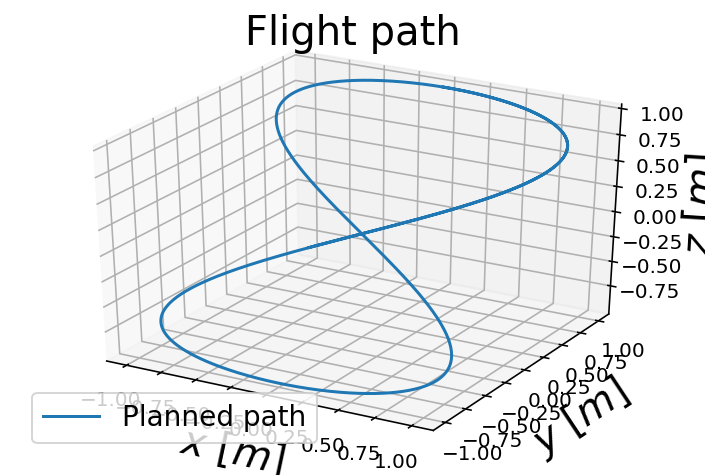

In [30]:
total_time = 20.0
dt = 0.01

t=np.linspace(0.0,total_time,int(total_time/dt))

omega_x = 0.8
omega_y = 0.4
omega_z = 0.4

a_x = 1.0 
a_y = 1.0
a_z = 1.0

x_path= a_x * np.sin(omega_x * t) 
x_dot_path= a_x * omega_x * np.cos(omega_x * t)
x_dot_dot_path= -a_x * omega_x**2 * np.sin(omega_x * t)

y_path= a_y * np.cos(omega_y * t)
y_dot_path= -a_y * omega_y * np.sin(omega_y * t)
y_dot_dot_path= -a_y * omega_y**2 * np.cos(omega_y * t)

z_path= a_z * np.cos(omega_z * t)
z_dot_path= -a_z * omega_z * np.sin(omega_z * t)
z_dot_dot_path= - a_z * omega_z**2 * np.cos(omega_z * t)

psi_path= np.arctan2(y_dot_path,x_dot_path)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x_path, y_path, z_path)
plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned path'],fontsize = 14)
plt.figure(figsize=(10,10))
plt.show()

### Plotting the drone's headings

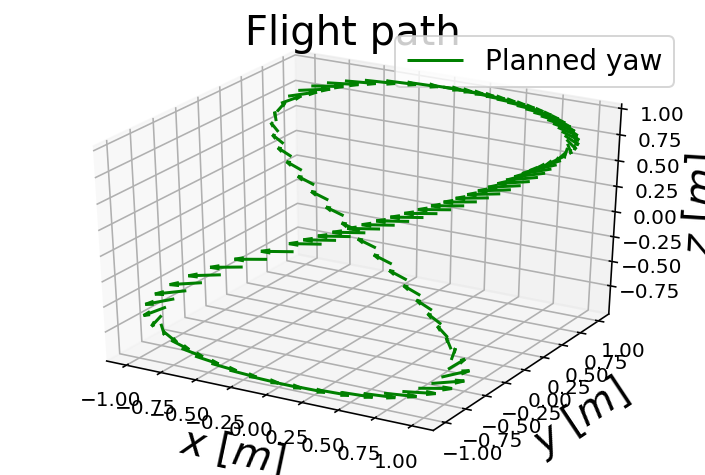

In [31]:
fig = plt.figure()
ax = fig.gca(projection='3d')

u = np.cos(psi_path)
v = np.sin(psi_path)
w = np.zeros(psi_path.shape)
for i in range(0,z_path.shape[0],20):
    ax.quiver(x_path[i], y_path[i], z_path[i], u[i], v[i], w[i], length=0.2, normalize=True,color='green')

plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned yaw',],fontsize = 14)

plt.show()

# Executing the flight

在这里，会将整个系统设定好，并将无人机对象和控制器对象链接起来。然后，执行飞行任务，并比较执行结果和目标路径。
理解 for loop 里：
（1）关于状态的更新（Drone类）
（2）控制器的布局：lateral controller 和 altitude controller 在外，attitude controller 在内，但是所有的 history （记录） （drone_state_history、omega_history、accelerations、accelerations_history、angular_vel_history ）更新都是在外层。
（3）两个类怎么产生联系？

x: delta = 0.816  omega_n = 2.449
y: delta = 0.816  omega_n = 2.449
z: delta = 0.354  omega_n = 1.414


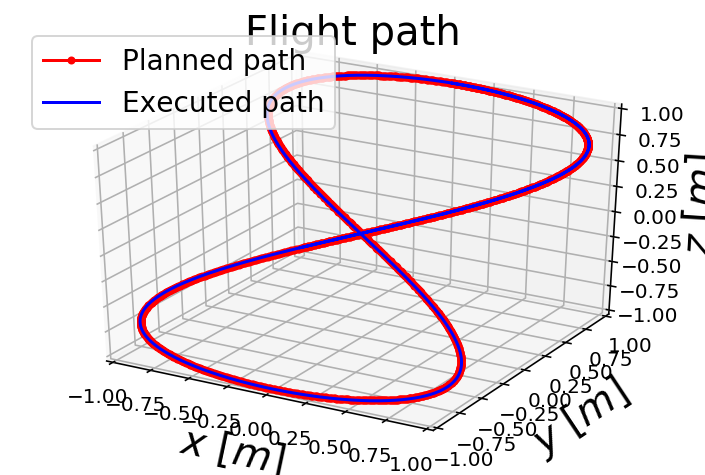

In [32]:
# how fast the inner loop (Attitude controller) performs calculations 
# relative to the outer loops (altitude and position controllers).
inner_loop_relative_to_outer_loop = 10

# creating the drone object
drone = DroneIn3D()
 
# creating the control system object 

control_system = Controller(z_k_p=2.0, 
                            z_k_d=1.0, 
                            x_k_p=6.0,
                            x_k_d=4.0,
                            y_k_p=6.0,
                            y_k_d=4.0,
                            k_p_roll=8.0,
                            k_p_pitch=8.0,
                            k_p_yaw=8.0,
                            k_p_p=20.0,
                            k_p_q=20.0,
                            k_p_r=20.0)



# declaring the initial state of the drone with zero
# height and zero velocity 

drone.X = np.array([x_path[0],
                               y_path[0],
                               z_path[0],
                               0.0,
                               0.0,
                               psi_path[0],
                               x_dot_path[0],
                               y_dot_path[0],
                               z_dot_path[0],
                               0.0,
                               0.0,
                               0.0])

# arrays for recording the state history, 
# propeller angular velocities and linear accelerations
# They all temporarily stored instantaneous values
drone_state_history = drone.X
omega_history = drone.omega
accelerations = drone.linear_acceleration()
accelerations_history= accelerations
angular_vel_history = drone.get_euler_derivatives()

# executing the flight
for i in range(0,z_path.shape[0]):
    
    rot_mat = drone.R()

    c = control_system.altitude_controller(z_path[i],
                                           z_dot_path[i],
                                           z_dot_dot_path[i],
                                           drone.X[2],
                                           drone.X[8],
                                           rot_mat)
    
    b_x_c, b_y_c = control_system.lateral_controller(x_path[i],
                                                     x_dot_path[i],
                                                     x_dot_dot_path[i],
                                                     drone.X[0],
                                                     drone.X[6],
                                                     y_path[i],
                                                     y_dot_path[i],
                                                     y_dot_dot_path[i],
                                                     drone.X[1],
                                                     drone.X[7],
                                                     c) 
    
    for _ in range(inner_loop_relative_to_outer_loop):
        
        rot_mat = drone.R()
        
        angular_vel = drone.get_euler_derivatives()
        
        u_bar_p, u_bar_q, u_bar_r = control_system.attitude_controller(
            b_x_c,
            b_y_c,
            psi_path[i],
            drone.psi,
            drone.X[9],
            drone.X[10],
            drone.X[11],
            rot_mat)
        
        drone.set_propeller_angular_velocities(c, u_bar_p, u_bar_q, u_bar_r)
        
        drone_state = drone.advance_state(dt/inner_loop_relative_to_outer_loop)
        
    # generating a history of the state history, propeller angular velocities and linear accelerations
    drone_state_history = np.vstack((drone_state_history, drone_state))
    
    omega_history=np.vstack((omega_history,drone.omega))
    accelerations = drone.linear_acceleration()
    accelerations_history= np.vstack((accelerations_history,accelerations))
    angular_vel_history = np.vstack((angular_vel_history,drone.get_euler_derivatives()))
    


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x_path, y_path, z_path,linestyle='-',marker='.',color='red')
ax.plot(drone_state_history[:,0],
         drone_state_history[:,1],
         drone_state_history[:,2],
         linestyle='-',color='blue')

plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned path','Executed path'],fontsize = 14)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.show()


# Flight path comparison 

对比无人机目标朝向和实际朝向（Yaw angle）

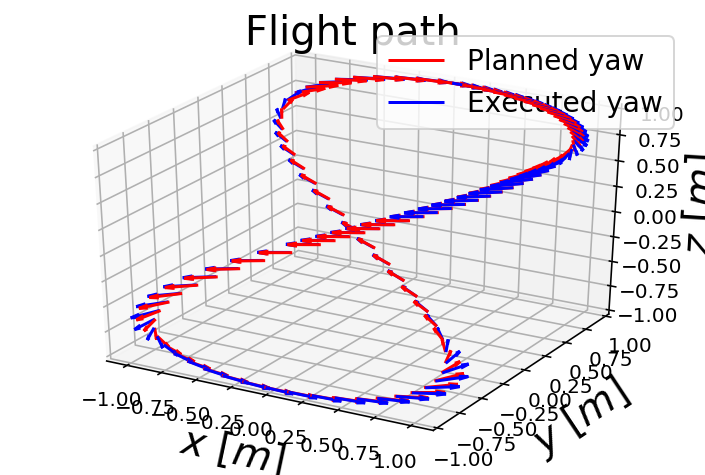

In [33]:
fig = plt.figure()
ax = fig.gca(projection='3d')

u = np.cos(psi_path)
v = np.sin(psi_path)
w = np.zeros(psi_path.shape)

drone_u = np.cos(drone_state_history[:,5])
drone_v = np.sin(drone_state_history[:,5])
drone_w = np.zeros(psi_path.shape)

for i in range(0,z_path.shape[0],20):
    ax.quiver(x_path[i], y_path[i], z_path[i], u[i], v[i], w[i], length=0.2, normalize=True,color='red')
    ax.quiver(drone_state_history[i,0], 
              drone_state_history[i,1], 
              drone_state_history[i,2], 
              drone_u[i], drone_v[i], drone_w[i], 
              length=0.2, normalize=True,color='blue')
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned yaw','Executed yaw'],fontsize = 14)

plt.show()

计算无人机的位置误差  $\epsilon^2(t) = \left(x_t(t)-x_a(t)\right)^2 + \left(y_t(t)-y_a(t)\right)^2+ \left(z_t(t)-z_a(t)\right)^2$.

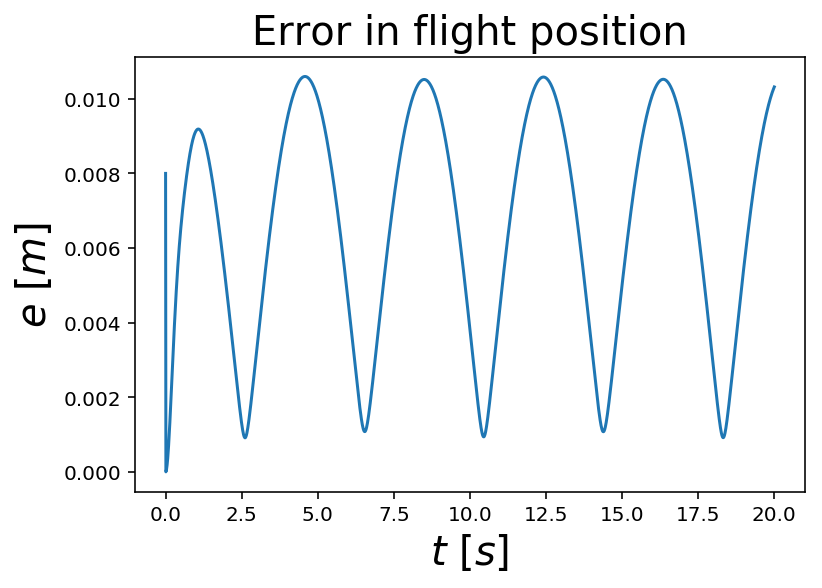

In [34]:
err= np.sqrt((x_path-drone_state_history[:-1,0])**2 
             +(y_path-drone_state_history[:-1,1])**2 
             +(y_path-drone_state_history[:-1,2])**2)


plt.plot(t,err)
plt.title('Error in flight position').set_fontsize(20)
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$e$ [$m$]').set_fontsize(20)
plt.show()

画出螺旋桨角速度随时间的变化曲线。
可以看出相对的螺旋桨（例如P1、P3）变化趋势是一致的，值的大小也接近，当值开始有明显差距时，表示无人机正在倾斜机体以产生侧向加速度。例如P1>P3,同时P2>P4时，无人机在pitch；而P1>P3,同时P2<P4时，无人机在roll。    
那么哪些位置可以看出无人机在yaw呢？当然是P1、P3这对螺旋桨的转速和P2、P4这对螺旋桨的转速有差距时。所以在这次任务中，无人机基本上一直在 yaw！且在t=2.5、t=6.25 ...这些时刻 yaw 运动的加速度最大。

In [35]:
plt.plot(t,-omega_history[:-1,0],color='blue')
plt.plot(t,omega_history[:-1,1],color='red')
plt.plot(t,-omega_history[:-1,2],color='green')
plt.plot(t,omega_history[:-1,3],color='black')

plt.title('Angular velocities').set_fontsize(20)
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$\omega$ [$rad/s$]').set_fontsize(20)
plt.legend(['P 1','P 2','P 3','P 4' ],fontsize = 14)

plt.grid()
plt.show()

画出无人机的 Yaw 角随时间的变化曲线。

In [36]:
plt.plot(t,psi_path,marker='.')
plt.plot(t,drone_state_history[:-1,5])
plt.title('Yaw angle').set_fontsize(20)
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$\psi$ [$rad$]').set_fontsize(20)
plt.legend(['Planned yaw','Executed yaw'],fontsize = 14)
plt.show()